In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip3 install mtcnn

     |████████████████████████████████| 2.3MB 5.8MB/s 


In [ ]:
!pip3 install keras_vggface

In [ ]:
%matplotlib inline

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle
from PIL import Image
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from scipy.spatial.distance import cosine

import os, cv2, random, glob
input_shape=(250, 250, 3)

Using TensorFlow backend.


In [ ]:
model = tf.keras.models.load_model("/content/drive/My Drive/own_base_model.h5")
# model = tf.keras.applications.Xception(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(128, 128, 3),
#     pooling='max',
#     classifier_activation="softmax",
# )

In [ ]:
test = cv2.imread("/content/drive/My Drive/JK1.jpg")
detector = MTCNN()

faces = detector.detect_faces(test)
for face in faces:
  print(face)

{'box': [329, 73, 416, 538], 'confidence': 0.9993719458580017, 'keypoints': {'left_eye': (512, 302), 'right_eye': (688, 284), 'nose': (660, 414), 'mouth_left': (521, 487), 'mouth_right': (691, 472)}}


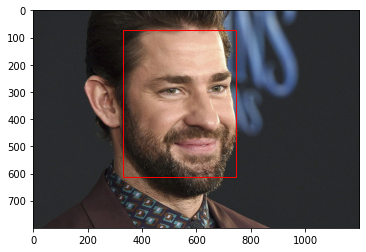

In [ ]:
def highlight_faces(image_path, faces):
  # display image
    image = plt.imread(image_path)
    plt.imshow(image)

    ax = plt.gca()

    # for each face, draw a rectangle based on coordinates
    for face in faces:
        x, y, width, height = face['box']
        face_border = Rectangle((x, y), width, height,
                          fill=False, color='red')
        ax.add_patch(face_border)
    plt.show()

highlight_faces('/content/drive/My Drive/JK1.jpg', faces)


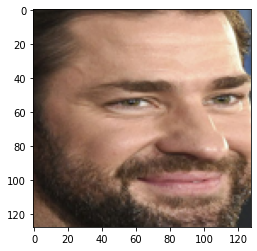

In [ ]:
def extract_face_from_image(image_path, required_size=(128, 128)):
  # load image and detect faces
    image = plt.imread(image_path)
    detector = MTCNN()
    faces = detector.detect_faces(image)

    face_images = []

    for face in faces:
        # extract the bounding box from the requested face
        x1, y1, width, height = face['box']
        x2, y2 = x1 + width, y1 + height

        # extract the face
        face_boundary = image[y1:y2, x1:x2]

        # resize pixels to the model size
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize(required_size)
        face_array = np.asarray(face_image)
        face_images.append(face_array)

    return face_images

extracted_face = extract_face_from_image('/content/drive/My Drive/JK1.jpg')

# Display the first face from the extracted faces
plt.imshow(extracted_face[0])
plt.show()

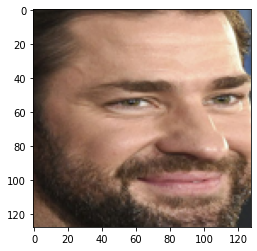

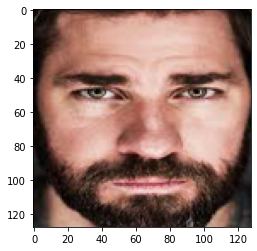

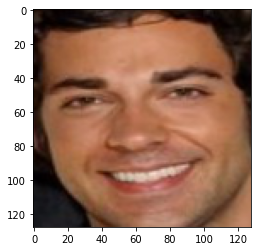

In [ ]:
extract_a = extract_face_from_image('/content/drive/My Drive/JK1.jpg')[0]
extract_b = extract_face_from_image('/content/drive/My Drive/JK2.jpg')[0]
extract_c = extract_face_from_image('/content/drive/My Drive/JK3.jpg')[0]
plt.imshow(extract_a)
plt.show()
plt.imshow(extract_b)
plt.show()
plt.imshow(extract_c)
plt.show()

In [ ]:
many_img = glob.glob("/content/drive/My Drive/many_images/*")
x_train = many_img[1:]

In [ ]:
def plot_triplets(examples):
  for i in range(3):
    plt.subplot(1, 3, 1 + i)
    plt.imshow(np.reshape(examples[i], (128, 128, 3)), cmap='binary')
    plt.xticks([])
    plt.yticks([])
  plt.show()

In [ ]:
emb_size = 128
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, traindir, batch_size=32):
    self.traindir = traindir
    self.batch_size = batch_size

  def __len__(self):
    return int(np.floor(len(self.traindir) / self.batch_size))

  def __getitem__(self, index):
    while True:
        x = self.create_batch()
        y = np.zeros((self.batch_size, 3*emb_size))
        return x, y

  def create_batch(self):#add self
    x_anchors = np.zeros((self.batch_size, 128, 128, 3))
    x_positives = np.zeros((self.batch_size, 128, 128, 3))
    x_negatives = np.zeros((self.batch_size, 128, 128, 3))
    for i in range(0, self.batch_size):
      train_dir = self.traindir
      random_index = random.randint(0, len(train_dir) - 1)

      person_selected = train_dir[random_index]
      imgs = glob.glob(person_selected + '/*') 

      img_index = random.randint(0, len(imgs) - 1)

      x_anchor = extract_face_from_image(imgs[img_index])[0]
      x_anchor = x_anchor.astype('float32')
      x_anchor /= 255.
      # x_anchor = np.expand_dims(x_anchor, axis=2)

      imgs.remove(imgs[img_index])

      x_positive = extract_face_from_image(imgs[random.randint(0, len(imgs) - 1)])[0]
      x_positive = x_positive.astype('float32')
      x_positive /= 255.
      # x_positive = np.expand_dims(x_positive, axis=2)

      negative_imgs = glob.glob("/content/drive/My Drive/lfw_funneled/*/")
      random_index = random.randint(0, len(negative_imgs) - 1)
      negative_person = negative_imgs[random_index]
      x_negative = extract_face_from_image(glob.glob(negative_person + "*")[0])[0]
      x_negative = x_negative.astype('float32')
      x_negative /= 255.
      # x_negative = np.expand_dims(x_negative, axis=2)

      x_anchors[i] = x_anchor
      x_positives[i] = x_positive
      x_negatives[i] = x_negative

    return [x_anchors, x_positives, x_negatives]


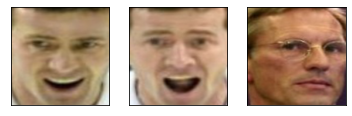

In [ ]:
gg = DataGenerator(x_train, batch_size=1)
plot_triplets(gg.__getitem__(1)[0])

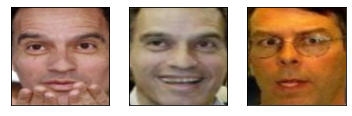

In [ ]:
a, b, c = gg.__getitem__(1)[0]
img_a = model.predict(a)
img_b = model.predict(b)
img_c = model.predict(c)
plot_triplets([a, b, c])

In [ ]:

img_a = np.squeeze(img_a)
img_b = np.squeeze(img_b)
img_c = np.squeeze(img_c)
def findCosineSimilarity(source_representation, test_representation):
 a = np.matmul(np.transpose(source_representation), test_representation)
 b = np.sum(np.multiply(source_representation, source_representation))
 c = np.sum(np.multiply(test_representation, test_representation))
 return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

cosine_similarity = findCosineSimilarity(img_a, img_c)
print("cosine similarity: ",cosine_similarity)
threshold = 0.1
if cosine_similarity < threshold:
 print("verified... they are same person")
else:
 print("unverified! they are not same person!")

cosine similarity:  0.12458747625350952
unverified! they are not same person!


In [ ]:
TP = 0
TN = 0
FP = 0 
FN = 0
threshold = 0.7
for i in range(1000):

  try:
    a, b, c = gg.__getitem__(1)[0]
    img_a = model.predict(a)
    img_b = model.predict(b)
    img_c = model.predict(c)

    # plot_triplets([a, b, c])
    print(i, "    ", a.shape, "    ", b.shape, "    ", c.shape )

    img_a = np.squeeze(img_a)
    img_b = np.squeeze(img_b)
    img_c = np.squeeze(img_c)


    case1 = findCosineSimilarity(img_a, img_b)*10**2
    if case1 < threshold:
      TP += 1
    else:
      FN += 1

    case2 = findCosineSimilarity(img_a, img_c)*10**2
    if case2 < threshold:
      FP += 1
    else:
      TN += 1

    case3 = findCosineSimilarity(img_b, img_c)*10**2
    if case3 < threshold:
      FP += 1
    else:
      TN += 1
  except ValueError:
    print("error")

In [ ]:
print(TP, FP, TN, FN)

680 105 1283 14
